- functioning NMT model
- attention model using classes
- bi-directional LSTMs in Encoder
- training works – loss goes down after 5 epochs
- pre-trained embeddings incorporated
- Check the final evaluation function – needs to be adapted

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional, Concatenate, LSTM, Embedding, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.initializers import Constant
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import re
import os
import io
import time

#import plotly.graph_objects as go


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

df_en_de = pd.read_table('/content/gdrive/MyDrive/deu-eng/deu.txt', names=['eng', 'deu', 'attr'])

Mounted at /content/gdrive


In [3]:
#df_en_de = pd.read_table('deu-eng/deu.txt', names=['eng', 'deu', 'attr'])
df_en_de = df_en_de.drop('attr',axis = 1).rename(columns = {'eng':'english', 'deu':'german'})

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub("'", '', sentence)
    sentence = sentence.replace('ü', 'ue').replace('ä', 'ae').replace('ö', 'oe').replace('ß', 'ss')
    exclude = set(string.punctuation)
    sentence = ''.join(ch for ch in sentence if ch not in exclude)
    sentence = 'start_ ' + sentence + ' _end'
    sentence = sentence.encode("ascii", "ignore")
    sentence = sentence.decode()
    return sentence

In [32]:
pairs = df_en_de
pairs = pairs.sample(frac = 0.1)
pairs['english'] = pairs['english'].apply(preprocess_sentence)
pairs['german'] = pairs['german'].apply(preprocess_sentence)

In [33]:
source = pairs['english']
target = pairs ['german']

In [34]:
# create tokenizer & tensor for source and target
source_sentence_tokenizer= Tokenizer(filters='')
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor, padding='post' )

target_sentence_tokenizer= Tokenizer(filters='')
target_sentence_tokenizer.fit_on_texts(target)
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
target_tensor= tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding='post' )

In [35]:
# Create word to index and index to word mappings for source and target

source_word_index = source_sentence_tokenizer.word_index
target_word_index = target_sentence_tokenizer.word_index

source_index_word = source_sentence_tokenizer.index_word
target_index_word = target_sentence_tokenizer.index_word

In [9]:
!python -m spacy download en_core_web_lg
import en_core_web_lg

!python -m spacy download de_core_news_sm
import de_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 587.7 MB 8.9 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 543 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [36]:
nlp_source = en_core_web_lg.load()
nlp_target = de_core_news_sm.load()

In [37]:
vocab_len_source = len(source_word_index.keys())
vocab_len_target = len(target_word_index.keys())
vocab_len_source, vocab_len_target


(7455, 12048)

In [38]:
num_tokens_source = vocab_len_source + 1
num_tokens_target = vocab_len_target + 1

In [39]:
# source language embedding dimensions
embedding_dim_source = len(nlp_source('The').vector)
# initialise embedding matrix for source language
embedding_matrix_source = np.zeros((num_tokens_source, embedding_dim_source))
for word, i in source_word_index.items():
    embedding_vector = nlp_source(word).vector
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_source[i] = embedding_vector

# target language embedding dimensions
embedding_dim_target = len(nlp_target('Der').vector)
# initialise embedding matrix for target language
embedding_matrix_target = np.zeros((num_tokens_target, embedding_dim_target))
for word, i in target_word_index.items():
    embedding_vector = nlp_target(word).vector
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_target[i] = embedding_vector

In [40]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor = train_test_split(
                                                                source_tensor, target_tensor,test_size=0.2
                                                                )

In [41]:
max_target_length= max(len(t) for t in  target_tensor)
max_source_length= max(len(t) for t in source_tensor)

In [42]:
max_target_length, max_source_length

(46, 39)

In [43]:
BATCH_SIZE = 32
#Create data in memeory 
dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BATCH_SIZE)
# shuffles the data in the batch
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [44]:
source_batch, target_batch =next(iter(dataset))
print(source_batch.shape, target_batch.shape)
print(source_batch[1])

(32, 39) (32, 46)
tf.Tensor(
[   1    5 2420  194   15   31    7  407    2    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0], shape=(39,), dtype=int32)


In [45]:
BUFFER_SIZE = len(source_train_tensor)
steps_per_epoch= BUFFER_SIZE//BATCH_SIZE
embedding_dim= 256
units= 256
attention_layer_units = 100
source_vocab_size= len(source_sentence_tokenizer.word_index)+1
target_vocab_size= len(target_sentence_tokenizer.word_index)+1

In [46]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size = num_tokens_source, embedding_dim = embedding_dim_source, 
                    encoder_units = units, batch_size=BATCH_SIZE):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.encoder_units = encoder_units
        self.embedding = Embedding(vocab_size, embedding_dim, 
                                    embeddings_initializer = Constant(embedding_matrix_source),
                                    trainable = False)
        self.lstm= Bidirectional(LSTM (encoder_units, 
                                      return_sequences=True,
                                      return_state=True,                                      
                                      recurrent_initializer='glorot_uniform'
                                     ))
    def call(self, x):
                                                                # x = (m, Tx)
                                                                # hidden = (m, encoder_units)
                                                                
        x = self.embedding(x)                                   # x = (m, Tx, embedding_dim)
        # pass input x through bi-directional LSTM
                                                                
        (enc_sequential, enc_forward_h, 
        enc_forward_c, enc_backward_h, enc_backward_c) = self.lstm(x)

        # concatenate forward and backward states
        enc_final_h = Concatenate()([enc_forward_h, enc_backward_h])
        enc_final_c = Concatenate()([enc_forward_c, enc_backward_c])

        return enc_sequential, enc_final_h, enc_final_c                     # enc_sequential = (m, Tx, 2 * encoder_units) 
                                                                            # enc_h = (m, 2 * encoder_units)
                                                                            # enc_c = (m, 2 * encoder_units)
    
    # def initialize_state(self):
    #     return tf.zeros((self.batch_size, self.encoder_units))
    

In [47]:
# check dimensions
encoder = Encoder(num_tokens_source, embedding_dim_source, units, BATCH_SIZE)

#initial_state = encoder.initialize_state()
enc_sequential, enc_final_h, enc_final_c = encoder(source_batch)

print (f'Encoder sequential: {enc_sequential.shape}')
print (f'Encoder final state_h: {enc_final_h.shape}')
print (f'Encoder final state_c: {enc_final_c.shape}')

Encoder sequential: (32, 39, 512)
Encoder final state_h: (32, 512)
Encoder final state_c: (32, 512)


In [48]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super( BahdanauAttention, self).__init__()
        self.W1= tf.keras.layers.Dense(units)  # decoder hidden (at time-step "t-1")
        self.W2= tf.keras.layers.Dense(units)  # encoder hidden (at time-step "t")
        self.V= tf.keras.layers.Dense(1)
    
    def call(self, dec_hidden, enc_hidden):
                                                                # dec_hidden = (m, 2*units) 
                                                                # enc_hidden:   (m, Tx, 2*units)

        dec_hidden_with_time = tf.expand_dims(dec_hidden, 1)    # dec_hidden_with_time = (m, 1, 2*units)
        
                                                                
        # W1() = (m, 1, 10) 
        # W2() = (m, Tx, 10)
        # Broadcasting happens when you add
        # W1() + W2 () = (m, Tx, 10)

        score = self.V(tf.nn.tanh(self.W1(dec_hidden_with_time) + self.W2(enc_hidden))) # (m, Tx, 1)
        
        # normalise scores with softmax
        attention_weights = tf.nn.softmax(score, axis=1)                                # (m, Tx, 1)
        
        # apply each weight to encoder hidden state at respective time-step 
        context_vector= attention_weights * enc_hidden                                  # (m, Tx, 2*units)
       
        # linear combination of enc_hidden vectors for all Tx
        # so sum along Tx axis
        context_vector = tf.reduce_sum(context_vector, axis=1)                          # (m, 2*units)
        return context_vector, attention_weights

In [49]:
attention_layer= BahdanauAttention(attention_layer_units)
attention_result, attention_weights = attention_layer(enc_final_h, enc_sequential)
print(f"context vector: (batch size, units) {attention_result.shape}")
print(f"attention weights: (batch_size, sequence_length, 1) {attention_weights.shape}")

context vector: (batch size, units) (32, 512)
attention weights: (batch_size, sequence_length, 1) (32, 39, 1)


In [50]:
# Decoder for one time-step

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size = num_tokens_target, embedding_dim = embedding_dim_target, 
                    decoder_units = 2*units, batch_sz=BATCH_SIZE):
        super (Decoder,self).__init__()
        self.batch_sz= batch_sz
        self.decoder_units = decoder_units
        self.embedding = Embedding(vocab_size, embedding_dim,
                                    embeddings_initializer = Constant(embedding_matrix_target),
                                    trainable = False)
        self.lstm= LSTM (decoder_units, 
                        return_sequences= True,
                        return_state=True,
                        recurrent_initializer='glorot_uniform')
        # Fully connected layer
        self.fc= Dense(vocab_size)      # Note, we don't use an activation here.
                                        # For the calculation of the loss, we will use 
                                        # sparse_softmax_cross_entropy_with_logits, which performs 
                                        # the softmax on the logits internally for greater efficiency
        
        # attention
        self.attention = BahdanauAttention(attention_layer_units)
    
    def call(self, y, dec_h, dec_c, enc_sequential):
                                                                                    # dec_h: (m, 2*units) 
                                                                                    # dec_c: (m, 2*units)
                                                                                    # enc_sequential: (m, Tx, 2*units) 

        context_vector, attention_weights = self.attention(dec_h, enc_sequential)   # context_vector = (m, 2*units)
        
        y= self.embedding(y)                                                        # y = (m, 1, embedding_dim)
        
        # concatenate context vector and embedding for output sequence
        y = tf.concat([tf.expand_dims(context_vector, 1), y],                       # (m, 1, 2*units) + (m, 1, embedding_dim)
                                      axis=-1)                                      # (m, 1, 2*units + embedding_dim)
        
        # passing the concatenated vector to the GRU
        output, dec_h, dec_c = self.lstm(y, initial_state = [dec_h, dec_c])                                         # output = (m, 1, 2*units)
                                                                                    # dec_h = (m, 2*units)
                                                                                    # dec_c = (m, 2*units)

        output= tf.reshape(output, (-1, output.shape[2]))                           # output = (m, 2*units)
        
        # pass the output thru Fc layers
        y = self.fc(output)                                                         # y = (m, vocab_size)
        return y, dec_h, dec_c, attention_weights

In [51]:
# Make sure to pass in "2*units", since the encoder uses bi-directional LSTM
# We're feeding final_h and final_c from Encoder as init_h and init_c for Decoder
decoder= Decoder(num_tokens_target, embedding_dim_target, 2*units, BATCH_SIZE)

sample_decoder_output, _, _, _ = decoder(tf.random.uniform((BATCH_SIZE,1)), enc_final_h, enc_final_c, enc_sequential)
print (f'Decoder output shape: (batch_size, vocab size) {sample_decoder_output.shape}')

Decoder output shape: (batch_size, vocab size) (32, 12049)


In [52]:
#Define the optimizer and the loss function
optimizer = tf.keras.optimizers.Adam()

In [53]:
def loss_function(real, pred):      # "real" = (m, 1), "pred" = (m, vocab_size)
    mask = 1 - np.equal(real, 0)    # mask = 1 when "real" != 0
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [54]:
EPOCHS = 5

# initial_state = encoder.initialize_state()
# enc_sequential, enc_final_h, enc_final_c = encoder(source_batch, initial_state)
# sample_decoder_output, _, _, _ = decoder(tf.random.uniform((BATCH_SIZE,1)), enc_final_h, enc_final_c, enc_sequential)
# decoder returns: y, dec_h, dec_c, attention_weights

for epoch in range(EPOCHS):
    start = time.time()
    
    #initial_state = encoder.initialize_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
                                                        # inp: (batch_size, Tx)
                                                        # targ: (batch_size, Ty)
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_sequential, enc_final_h, enc_final_c = encoder(inp)
            
            dec_h = enc_final_h
            dec_c = enc_final_c
            
            dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)    # (m, 1)   
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_h, dec_c, _ = decoder(dec_input, dec_h, dec_c, enc_sequential) # predictions = (m, vocab_size)
                
                loss += loss_function(targ[:, t], predictions)
                
                # update dec_input for teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {batch_loss.numpy():.4f}')
    
    print(f'Epoch {epoch + 1} Loss {total_loss / steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time() - start} sec\n')

Epoch 1 Batch 0 Loss 1.4376
Epoch 1 Batch 50 Loss 0.9824
Epoch 1 Batch 100 Loss 0.8126
Epoch 1 Batch 150 Loss 0.8483
Epoch 1 Batch 200 Loss 0.8587
Epoch 1 Batch 250 Loss 0.9609
Epoch 1 Batch 300 Loss 0.7808
Epoch 1 Batch 350 Loss 0.7228
Epoch 1 Batch 400 Loss 0.7182
Epoch 1 Batch 450 Loss 0.7975
Epoch 1 Batch 500 Loss 0.6492
Epoch 1 Batch 550 Loss 0.5915
Epoch 1 Batch 600 Loss 0.6335
Epoch 1 Loss 0.7912
Time taken for 1 epoch 900.5637888908386 sec

Epoch 2 Batch 0 Loss 0.5242
Epoch 2 Batch 50 Loss 0.6184
Epoch 2 Batch 100 Loss 0.6229
Epoch 2 Batch 150 Loss 0.6021
Epoch 2 Batch 200 Loss 0.6716
Epoch 2 Batch 250 Loss 0.5992
Epoch 2 Batch 300 Loss 0.5007
Epoch 2 Batch 350 Loss 0.4974
Epoch 2 Batch 400 Loss 0.4990
Epoch 2 Batch 450 Loss 0.5382
Epoch 2 Batch 500 Loss 0.4249
Epoch 2 Batch 550 Loss 0.5767
Epoch 2 Batch 600 Loss 0.4657
Epoch 2 Loss 0.5716
Time taken for 1 epoch 894.9653878211975 sec

Epoch 3 Batch 0 Loss 0.4447
Epoch 3 Batch 50 Loss 0.4436
Epoch 3 Batch 100 Loss 0.4850
Epoch 3

In [59]:
EPOCHS = 5

# initial_state = encoder.initialize_state()
# enc_sequential, enc_final_h, enc_final_c = encoder(source_batch, initial_state)
# sample_decoder_output, _, _, _ = decoder(tf.random.uniform((BATCH_SIZE,1)), enc_final_h, enc_final_c, enc_sequential)
# decoder returns: y, dec_h, dec_c, attention_weights

for epoch in range(EPOCHS):
    start = time.time()
    
    #initial_state = encoder.initialize_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
                                                        # inp: (batch_size, Tx)
                                                        # targ: (batch_size, Ty)
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_sequential, enc_final_h, enc_final_c = encoder(inp)
            
            dec_h = enc_final_h
            dec_c = enc_final_c
            
            dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)    # (m, 1)   
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_h, dec_c, _ = decoder(dec_input, dec_h, dec_c, enc_sequential) # predictions = (m, vocab_size)
                
                loss += loss_function(targ[:, t], predictions)
                
                # update dec_input for teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 50 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {batch_loss.numpy():.4f}')
    
    print(f'Epoch {epoch + 1} Loss {total_loss / steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time() - start} sec\n')

Epoch 1 Batch 0 Loss 0.2029
Epoch 1 Batch 50 Loss 0.2362
Epoch 1 Batch 100 Loss 0.2442
Epoch 1 Batch 150 Loss 0.2240
Epoch 1 Batch 200 Loss 0.2404
Epoch 1 Batch 250 Loss 0.2172
Epoch 1 Batch 300 Loss 0.2422
Epoch 1 Batch 350 Loss 0.2447
Epoch 1 Batch 400 Loss 0.1877
Epoch 1 Batch 450 Loss 0.2620
Epoch 1 Batch 500 Loss 0.1719
Epoch 1 Batch 550 Loss 0.2007
Epoch 1 Batch 600 Loss 0.2154
Epoch 1 Loss 0.2306
Time taken for 1 epoch 904.5027527809143 sec

Epoch 2 Batch 0 Loss 0.1654
Epoch 2 Batch 50 Loss 0.2275
Epoch 2 Batch 100 Loss 0.2099
Epoch 2 Batch 150 Loss 0.1595
Epoch 2 Batch 200 Loss 0.1956
Epoch 2 Batch 250 Loss 0.2492
Epoch 2 Batch 300 Loss 0.1555
Epoch 2 Batch 350 Loss 0.1973
Epoch 2 Batch 400 Loss 0.1873
Epoch 2 Batch 450 Loss 0.1316
Epoch 2 Batch 500 Loss 0.1835
Epoch 2 Batch 550 Loss 0.1440
Epoch 2 Batch 600 Loss 0.1805
Epoch 2 Loss 0.1926
Time taken for 1 epoch 901.0081508159637 sec

Epoch 3 Batch 0 Loss 0.1563
Epoch 3 Batch 50 Loss 0.1823
Epoch 3 Batch 100 Loss 0.1614
Epoch 3

In [60]:
def evaluate(inputs, encoder, decoder, max_source_length, max_target_length):
    # inputs = (1, Tx)

    attention_plot = np.zeros((max_target_length, max_source_length))
    
    input_sentence = ''
    for i in inputs[0]:
        if i == 0:
            break
        input_sentence = input_sentence + source_sentence_tokenizer.index_word[i] + ' '
    #input_sentence = input_sentence[:-1]
    

    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    # Encoder: 
    # Input: x, init_state
    # Return: enc_sequential, enc_final_h, enc_final_c

    init_state = [tf.zeros((1, units))]
    enc_sequential, enc_final_h, enc_final_c = encoder(inputs)

    dec_h = enc_final_h
    dec_c = enc_final_c
    
    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)             # dec_input = (1, 1)

    # Decoder:
    # Input: y, dec_h, dec_c, enc_sequential
    # Return: y, dec_h, dec_c, attention_weights

    # start decoding
    for t in range(max_target_length): # limit the length of the decoded sequence
        predictions, dec_h, dec_c, attention_weights = decoder(dec_input, dec_h, dec_c, enc_sequential)    # predictions = (1, vocab_size)
                                                                                                           # dec_h = (1, 2*units)
                                                                                                           # dec_c = (1, 2*units)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += target_sentence_tokenizer.index_word[predicted_id] + ' '

        # stop decoding if '_end' is predicted
        if target_sentence_tokenizer.index_word[predicted_id] == '_end':
            return result, input_sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)                                         # dec_input = (1,1)  

    return result, input_sentence, attention_plot
  
def predict_random_val_sentence():
    
    k = np.random.randint(len(source_train_tensor))
    random_input = source_train_tensor[k]
    random_output = target_train_tensor[k]
    random_input = np.expand_dims(random_input,0)           # random_input = (1, Tx)
    result, sentence, attention_plot = evaluate(random_input, encoder, decoder, max_source_length, max_target_length)
    print(f'Input: {sentence[7:-5]}')                   # Want to skip "start_ " and " _end"
    print(f'Predicted translation: {result[:-5]}')
    true_translation = ''
    for i in random_output:
        if i == 0:
            break
        true_translation = true_translation + target_sentence_tokenizer.index_word[i] + ' '
    true_translation = true_translation[7:-6]               # Want to skip "start_" and " _end "
    print(f'Actual translation: {true_translation}')
    
    attention_plot = attention_plot[:len(result.split(' '))-2, 1:len(sentence.split(' '))-1]
    sentence, result = sentence.split(' '), result.split(' ')
    sentence = sentence[1:-1]
    result = result[:-2]
    sns.heatmap(attention_plot, cmap = 'hot', annot = True, xticklabels = sentence, yticklabels = result)


Input: tom learned how to ride a bicycle from his older brother 
Predicted translation: tom ist wie gross von seiner familie von einem kleinen mann 
Actual translation: tom hat von seinem aelteren bruder fahrradfahren gelernt


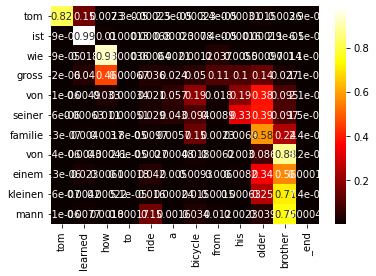

In [61]:
predict_random_val_sentence()

Input: one by one the boys came to see what i was reading 
Predicted translation: einer jungen kamen ich als ich zu lesen las 
Actual translation: die jungen kamen einer nach dem anderen um zu sehen was ich da las


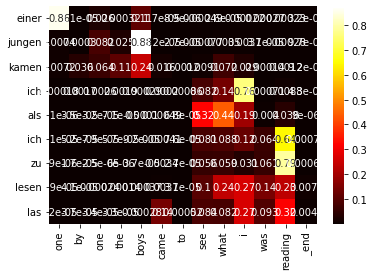

In [62]:
predict_random_val_sentence()

Input: does tom travel much 
Predicted translation: reist tom viel 
Actual translation: reist tom viel


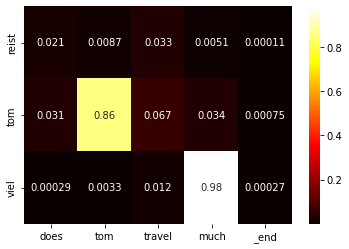

In [63]:
predict_random_val_sentence()

Input: whos tom with 
Predicted translation: wer ist mit tom 
Actual translation: mit wem ist tom beisammen


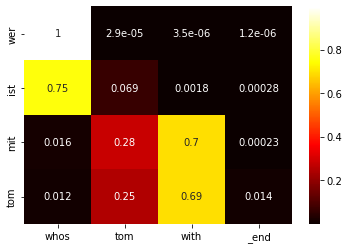

In [64]:
predict_random_val_sentence()

Input: tom imitated mary 
Predicted translation: tom ahmte maria 
Actual translation: tom ahmte maria nach


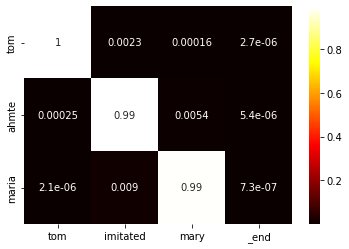

In [65]:
predict_random_val_sentence()

Input: ill get the ladder 
Predicted translation: ich werde den weg 
Actual translation: ich hole die leiter


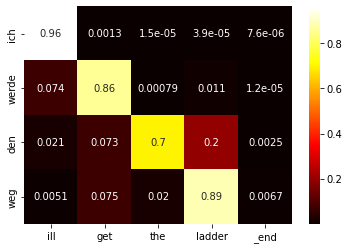

In [66]:
predict_random_val_sentence()

Input: she is ethiopian 
Predicted translation: sie ist aethiopierin 
Actual translation: sie ist aethiopierin


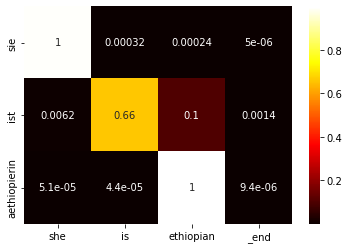

In [67]:
predict_random_val_sentence()